In [1]:
using PyPlot

# Monte Carlo sampling for evaluation of partition functions

## Metropolis

Let's implement the Metropolis algorithm for the 2D Ising model. For configurations, we'll use the same storage scheme as before.

In [2]:
spin(b::Bool) = Float64(2 * b - 1)

spin (generic function with 1 method)

To allow us to study different topologies, we will use a separate function to define what we mean by neighbouring sites.

In [3]:
neighbours_2D_PBC(nx::Int, ny::Int, Lx::Int, Ly::Int) = ((mod1(nx+1, Lx), ny), (mod1(nx-1, Lx), ny), 
    (nx, mod1(ny+1, Ly)), (nx, mod1(ny-1, Ly)))

neighbours_2D_PBC (generic function with 1 method)

Now we can actually implement the Metropolis update. This takes the configuration, as well as the coordinates nx and ny of a spin to try to flip.

In [4]:
function ising_metupd_2D_PBC!(c::BitArray{2}, nx::Int, ny::Int, h::Float64, Jx::Float64, Jy::Float64, β::Float64)
    Ly,Lx = size(c)
    
    nb_x1, nb_x2, nb_y1, nb_y2 = neighbours_2D_PBC(nx, ny, Lx, Ly)
    
    b = c[ny,nx]
    
    s = spin(b)
    sn_x = spin(c[nb_x1[2], nb_x1[1]]) + spin(c[nb_x2[2], nb_x2[1]])
    sn_y = spin(c[nb_y1[2], nb_y1[1]]) + spin(c[nb_y2[2], nb_y2[1]])
    
    e = -(h + Jx * sn_x + Jy * sn_y)
    
    amp = exp(2β * s * e)
    
    accept = rand() < amp #If amp<1, this will set accept to true with probability amp. If amp > 1, accept is always false.
    if accept
        c[ny, nx] = !b
    end
    
    accept
end

ising_metupd_2D_PBC! (generic function with 1 method)

Let's see what kind of configurations we can generate.

In [5]:
c = bitrand(10,10)

10×10 BitArray{2}:
  true   true   true   true  false  false  false  false  false   true
 false   true  false   true   true   true  false   true  false   true
 false  false   true   true   true   true  false  false   true  false
 false   true  false   true  false  false   true   true   true   true
  true   true  false   true   true   true  false   true  false   true
  true   true   true  false   true  false   true  false  false  false
 false   true  false  false  false  false   true  false  false  false
  true  false  false   true   true  false   true   true   true  false
  true  false   true   true   true  false   true   true   true   true
 false   true  false  false   true  false   true  false   true   true

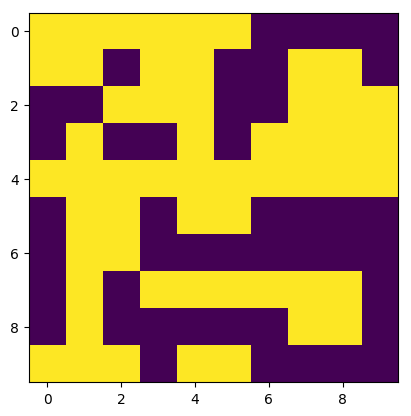

PyObject <matplotlib.image.AxesImage object at 0x7f0a79420b38>

In [6]:
let h = 0.0, Jx = 1.0, Jy = 1.0, T = 2.2
    Ly,Lx = size(c)
    for j in 1:Lx*Ly
        nx = rand(1:Lx)
        ny = rand(1:Ly)
        ising_metupd_2D_PBC!(c, nx, ny, h, Jx, Jy, 1/T)
    end
    imshow(c, interpolation="nearest")
end

## Estimating a variable

We wish to estimate the magnetisation. First, we define a function to evaluate it on a configuration.

In [7]:
function ising_mag_2D_PBC(c::BitArray{2})::Float64
    Ly,Lx = size(c)
    N = Lx * Ly
    Nup = countnz(c) #counts the number of spins set to "true"
    
    (2Nup - N) / N
end

ising_mag_2D_PBC (generic function with 1 method)

This function evaluate the magnetization and adds it to a preexisting results array. It does the same for $M^2$. We will use this for sampling expectation values.

In [8]:
function ising_meas_mag_2D_PBC!(meas::AbstractMatrix{Float64}, nsweep::Int, c::BitArray{2})
    m = ising_mag_2D_PBC(c)
    
    #write to the results array
    meas[1,nsweep] = meas[1,nsweep] + m
    meas[2,nsweep] = meas[2,nsweep] + m^2
end

ising_meas_mag_2D_PBC! (generic function with 1 method)

Next let's define a function to gather measurements over a number of sweeps. We will take a "measfunc" argument that specifies a function that carried out the measurement. This way we can use this Monte-Carlo sampling routine for any measurement we want.

In [9]:
function ising_MC_2D_PBC(c::BitArray{2}, h::Float64, Jx::Float64, Jy::Float64, β::Float64, Nsweeps::Int; 
                         keep_cs::Bool=false, Nmeas::Int=2, measfunc=ising_meas_mag_2D_PBC!)
    Ly, Lx = size(c)
    N = Lx * Ly
    
    cs = BitArray{2}[]
    
    ms = zeros((Nmeas, Nsweeps))
    
    Racc = zeros(Nsweeps)
    
    for i in 1:Nsweeps
        acc = 0
        for j in 1:N
            nx = rand(1:Lx)
            ny = rand(1:Ly)
            acc += ising_metupd_2D_PBC!(c, nx, ny, h, Jx, Jy, β)
            measfunc(ms, i, c)
        end
        Racc[i] = acc / N
        if keep_cs
            push!(cs, copy(c))
        end
    end
    
    scale!(ms, 1/N)
    
    keep_cs ? (ms, Racc, cs) : ms, Racc
end

ising_MC_2D_PBC (generic function with 1 method)

### Getting results

To avoid autocorrelation effects, which lead to underestimation of the error, we use "binning" to extract reliable estimates. Binning is the division of measurements into blocks of $l_{\text{bin}}$ sequential measurements. The new samples are the averages within the blocks.

In [10]:
binmeas(meas::Vector{Float64}, lbin::Int) = vec(mean(reshape(meas, (lbin, length(meas) ÷ lbin)), 1))

binmeas (generic function with 1 method)

In [11]:
function measval(meas::Vector{Float64})
    m = mean(meas)
    m, √(varm(meas, m) / length(meas))
end

measval (generic function with 1 method)

### Test

Let's try out metropolis sampling for measuring the magnetization at the critical temperature.

 16.080244 seconds (10.24 k allocations: 5.136 MiB)
mean(Racc) = 0.18815567500000002

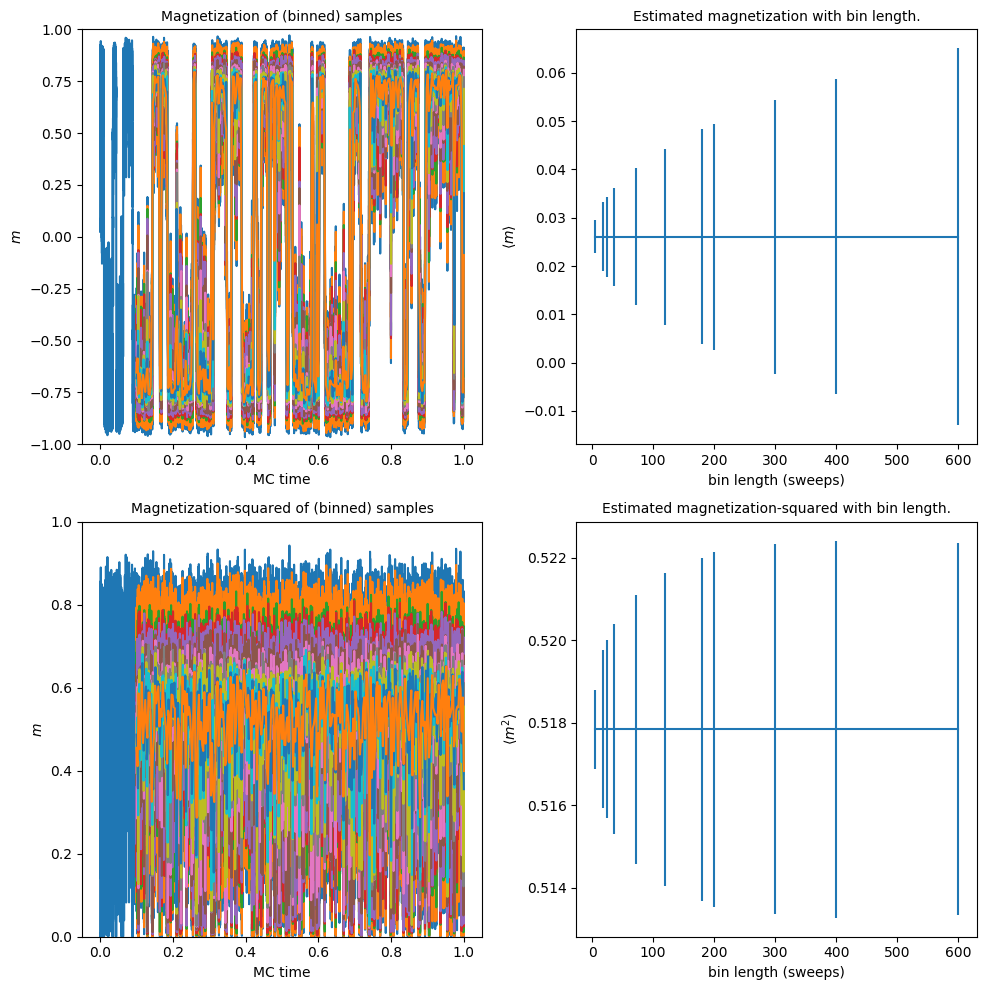

In [12]:
let Lx = 20, Ly = 20, h = +0.0, Jx = 1.0, Jy = 1.0, T = 2.269, Nsweep = 200000
    
    #Choose bin sizes. Must be compatible with the number of sweeps, after moving one tenth for burn-in.
    lbins = Int[4, 18, 24, 36, 72, 120, 180, 200, 300, 400, 600]
    
    N = Lx * Ly
    c = bitrand(Ly,Lx)
    @time meas, Racc = ising_MC_2D_PBC(c, h, Jx, Jy, 1.0/T, Nsweep, Nmeas=2, measfunc=ising_meas_mag_2D_PBC!)
    @show mean(Racc)
    
    meas = meas'
    ms = meas[:,1]
    m2s = meas[:,2]
    
    figure(figsize=(10,10))
    subplot(221)
    plot(linspace(0.0, 1.0, length(ms)), ms, label="1")
    
    ms = ms[length(ms)÷10+1:end] #burn-in
    
    avs = zeros(length(lbins))
    stds = zeros(length(lbins))
    
    for (j, lbin) in enumerate(lbins)
        msb = binmeas(ms, lbin)
        plot(linspace(0.1, 1.0, length(msb)), msb, label="$lbin")
        avs[j], stds[j] = measval(msb)
    end
    
    ylim((-1,+1))
    xlabel("MC time")
    ylabel(L"m")
    title("Magnetization of (binned) samples", fontsize=10)
    #legend()
    
    subplot(222)
    errorbar(lbins, avs, yerr=stds)
    xlabel("bin length (sweeps)")
    ylabel(L"\langle m \rangle")
    title("Estimated magnetization with bin length.", fontsize=10)

 
    subplot(223)
    plot(linspace(0.0, 1.0, length(m2s)), m2s, label="1")
    
    m2s = m2s[length(m2s)÷10+1:end] #burn-in
    
    avs = zeros(length(lbins))
    stds = zeros(length(lbins))
    
    for (j, lbin) in enumerate(lbins)
        m2sb = binmeas(m2s, lbin)
        plot(linspace(0.1, 1.0, length(m2sb)), m2sb, label="$lbin")
        avs[j], stds[j] = measval(m2sb)
    end
    
    ylim((0,+1))
    xlabel("MC time")
    ylabel(L"m")
    title("Magnetization-squared of (binned) samples", fontsize=10)
    #legend()
    
    subplot(224)
    errorbar(lbins, avs, yerr=stds)
    xlabel("bin length (sweeps)")
    ylabel(L"\langle m^2 \rangle")
    title("Estimated magnetization-squared with bin length.", fontsize=10)
    
    tight_layout()
end

We see lots of jumps in the magnetization. Also, that the error bars, especially for the magnetization, grow slowly with the bin size, suggests a lot of autocorrelation. Let's have a look at the sampling procedure...

## Ergodicity

Let us evaluate the Metropolis algorithm. After burn-in, it should take us through a selection of the most probable configurations. Let's check that on a small system. We're using the same functions we used in the partition function notebook to get the true probability of each configuration.

In [13]:
function ising_weight_2D_PBC(c::BitArray{2}, h::Float64, Jx::Float64, Jy::Float64, β::Float64)::Float64
    Ly,Lx = size(c)

    en = 0.0
    @inbounds @fastmath for k in 1:Lx, j in 1:Ly
        s = spin(c[j,k])
        en -= h * s
        en -= Jx * s * spin(c[j,mod1(k+1, Lx)])
        en -= Jy * s * spin(c[mod1(j+1, Ly),k])
    end
    
    exp(-en * β)
end

ising_weight_2D_PBC (generic function with 1 method)

In [14]:
function ising_pd_2D_PBC(Lx::Int, Ly::Int, h::Float64, Jx::Float64, Jy::Float64, β::Float64)
    N = Lx*Ly
    @assert N ≤ 64 "Up to 64 spins!" #Although it would take a *long* time, our implementation would do 64!
    c = BitArray(Ly,Lx)
    Ws = zeros(2^N)
    Ms = zeros(2^N)
    for j in 0:2^N-1
        c.chunks[1] = j
        W = ising_weight_2D_PBC(c, h, Jx, Jy, β)
        M = ising_mag_2D_PBC(c)
        Ws[j+1] = W
        Ms[j+1] = M
    end
    Z = sum(Ws)
    
    P = Ws ./ Z #normalize the weights to probabilities
    
    P, Ms, Z
end

ising_pd_2D_PBC (generic function with 1 method)

Now let's see how well Metropolis did at the critical temperature. We will use the raw samples to estimate the probability of a correlation and compare it to the exact result. This will show us autocorrelation issues.

  0.784639 seconds (10 allocations: 24.000 MiB)
acc / (Nsamp * meas_every) = 0.095
sum(P) = 

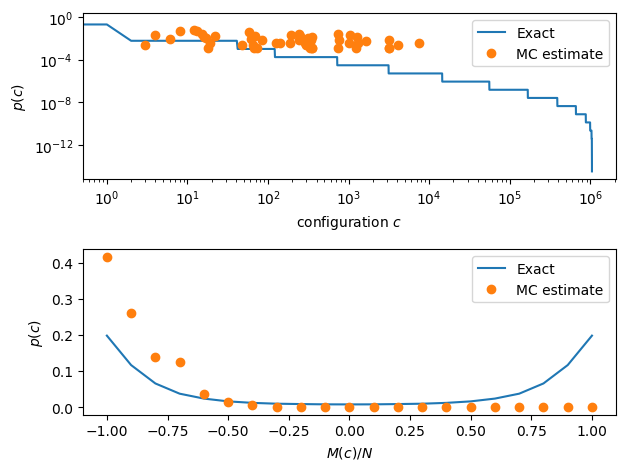

1.0000000000000033


In [21]:
let Lx = 4, Ly = 5, T = 2.269, Jx = 1.0, Jy = 1.0, h = 0.0, Nburn = 100, Nsamp = 800, meas_every = 1
    N = Lx * Ly
    @time P, Ms, Z = ising_pd_2D_PBC(Lx,Ly,h,Jx,Jy,1/T)
    
    visits = zeros(Int, length(P))
    c = bitrand(Ly,Lx)
    #burn in 
    for j in 1:Nburn
        nx = rand(1:Lx)
        ny = rand(1:Ly)
        ising_metupd_2D_PBC!(c, nx, ny, h, Jx, Jy, 1.0/T)
    end
    acc = 0
    for j in 1:Nsamp
        for k in 1:meas_every
            nx = rand(1:Lx)
            ny = rand(1:Ly)
            acc += ising_metupd_2D_PBC!(c, nx, ny, h, Jx, Jy, 1.0/T)
        end
        visits[c.chunks[1] + 1] += 1
    end
    @show acc / (Nsamp * meas_every)
    F = visits / Nsamp
    
    srt = sortperm(P, rev=true)
    P = P[srt]
    Ms = Ms[srt]
    F = F[srt]
    
    @show sum(P)
    Ws = P * Z
    Es = -log.(Ws) * T
    
    subplot(211)
    plot(P, label="Exact")
    plot(F, "o", label="MC estimate")
    xlabel(L"configuration $c$")
    ylabel(L"p(c)")
    yscale("log")
    xscale("log")
    legend()
    
    subplot(212)
    Ms_unique = sort(unique(Ms))
    PM = zeros(length(Ms_unique))
    FM = zeros(length(Ms_unique))
    for j in 1:length(Ms_unique)
        flt = Ms .== Ms_unique[j]
        PM[j] = sum(P[flt])
        FM[j] = sum(F[flt])
    end
    plot(Ms_unique, PM, label="Exact")
    plot(Ms_unique, FM, "o", label="MC estimate")
    xlabel(L"M(c)/N")
    ylabel(L"p(c)")
    #yscale("log")
    legend()
    
    tight_layout()
    
    #figure()
    #hist = fit(Histogram, Ms)
    #plot(hist.edges[1][2:end], hist.weights)
end

It seems the Metropolis algorithm breaks the spin-flip symmetry. This makes sense, since if we start magnetized it is very improbable to flip enough spins to cross over to the opposite magnetization, if we only flip one at a time. In other words, we expect strong autocorrelation problems, as we witnessed above. We would need to sample for a very long time to fix this. Alternatively, we can change our update algorithm.

## Cluster updates

To improve the ergodicity near the critical point, we can try a different update scheme, flipping multiple spins at once.

In [16]:
CoordPair = Tuple{Tuple{Int,Int},Tuple{Int,Int}}

Tuple{Tuple{Int64,Int64},Tuple{Int64,Int64}}

In [17]:
function ising_clustupd_2D_PBC!(c::BitArray{2}, cl::BitArray{2}, to_visit::Vector{CoordPair}, nx::Int, ny::Int, β::Float64)
    Ly,Lx = size(c)
    
    c_size = 1

    resize!(to_visit, 0)
    fill!(cl, false)
    cl[ny, nx] = true #mark first site

    #schedule first neighbours for a visit
    for nb in neighbours_2D_PBC(nx, ny, Lx, Ly)
        push!(to_visit, ((nx, ny), nb))
    end
    
    while !isempty(to_visit)
        (nx1,ny1), (nx2,ny2) = shift!(to_visit)

        cl[ny2, nx2] && continue
        
        b1 = c[ny1, nx1]
        b2 = c[ny2, nx2]
        
        if !xor(b1, b2) && rand() < 1.0 - exp(-2β)
            cl[ny2, nx2] = true
            c_size += 1
            nbs = neighbours_2D_PBC(nx2, ny2, Lx, Ly)
            for nb in nbs
                cl[nb[2], nb[1]] || push!(to_visit, ((nx2, ny2), nb))
            end
        end
    end
    
    #in-place update of configuration
    for j in 1:length(c.chunks)
        c.chunks[j] = xor(c.chunks[j], cl.chunks[j])
    end
    
    c_size
end

ising_clustupd_2D_PBC! (generic function with 1 method)

  0.845115 seconds (10 allocations: 24.000 MiB)
  0.005249 seconds (4.31 k allocations: 68.156 KiB)
c_frac = 15.01875000000008


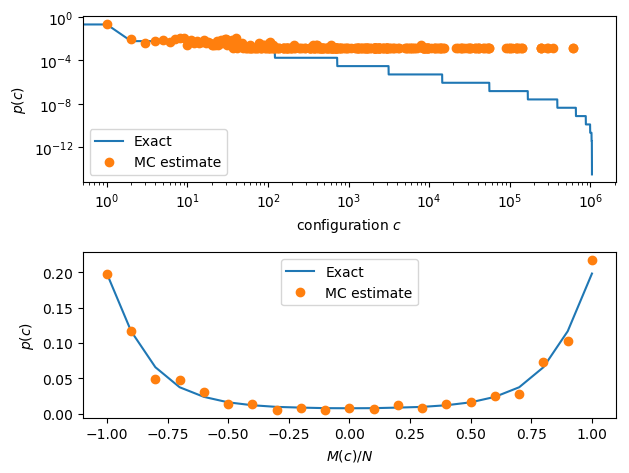

sum(P) = 1.0000000000000033


In [18]:
let Lx = 4, Ly = 5, T = 2.269, Nburn = 100, Nsamp = 800, Nupd = 1
    N = Lx * Ly
    @time P, Ms, Z = ising_pd_2D_PBC(Lx,Ly,0.0,1.0,1.0,1/T)
    
    visits = zeros(Int, length(P))
    c = bitrand(Ly,Lx)
    cl = falses(c)
    to_visit = CoordPair[]
    #burn in 
    for j in 1:Nburn
        nx = rand(1:Lx)
        ny = rand(1:Ly)
        ising_clustupd_2D_PBC!(c, cl, to_visit, nx, ny, 1.0/T)
    end
    c_frac = 0
    @time for j in 1:Nsamp
        for k in 1:Nupd
            nx = rand(1:Lx)
            ny = rand(1:Ly)
            c_frac += ising_clustupd_2D_PBC!(c, cl, to_visit, nx, ny, 1.0/T) / (Nsamp * Nupd)
        end
        visits[c.chunks[1] + 1] += 1
    end
    @show c_frac
    F = visits / Nsamp
    
    srt = sortperm(P, rev=true)
    P = P[srt]
    Ms = Ms[srt]
    F = F[srt]
    
    @show sum(P)
    Ws = P * Z
    Es = -log.(Ws) * T
    
    subplot(211)
    plot(P, label="Exact")
    plot(F, "o", label="MC estimate")
    xlabel(L"configuration $c$")
    ylabel(L"p(c)")
    yscale("log")
    xscale("log")
    legend()
    
    subplot(212)
    Ms_unique = sort(unique(Ms))
    PM = zeros(length(Ms_unique))
    FM = zeros(length(Ms_unique))
    for j in 1:length(Ms_unique)
        flt = Ms .== Ms_unique[j]
        PM[j] = sum(P[flt])
        FM[j] = sum(F[flt])
    end
    plot(Ms_unique, PM, label="Exact")
    plot(Ms_unique, FM, "o", label="MC estimate")
    xlabel(L"M(c)/N")
    ylabel(L"p(c)")
    #yscale("log")
    legend()
    
    tight_layout()
end

This is much more symmetric than the metropolis version!

In [19]:
function ising_MC_cluster_2D_PBC(c::BitArray{2}, β::Float64, Nsweeps::Int; 
                           keep_cs::Bool=false, Nmeas::Int=2, measfunc=ising_meas_mag_2D_PBC!)
    Ly, Lx = size(c)
    N = Lx * Ly
    
    cs = BitArray{2}[]
    
    ms = zeros((Nmeas, Nsweeps))
    
    c_fracs = zeros(Nsweeps)
    
    to_visit = CoordPair[]
    
    cl = falses(c)
    for i in 1:Nsweeps
        c_frac = 0.0
        Nupd = 0
        while c_frac < 1.0 #Note: Not obviously the most sensible choice for a sweep.
            nx = rand(1:Lx)
            ny = rand(1:Ly)
            c_frac += ising_clustupd_2D_PBC!(c, cl, to_visit, nx, ny, β)
            measfunc(ms, i, c)
            Nupd += 1
        end
        for k in 1:Nmeas
            ms[k,i] /= Nupd
        end
        
        c_fracs[i] = c_frac / Nupd
        if keep_cs
            push!(cs, copy(c))
        end
    end
    
    keep_cs ? (ms, c_fracs, cs) : ms, c_fracs
end

ising_MC_cluster_2D_PBC (generic function with 1 method)

mean(c_fracs) = 204.98090909090908

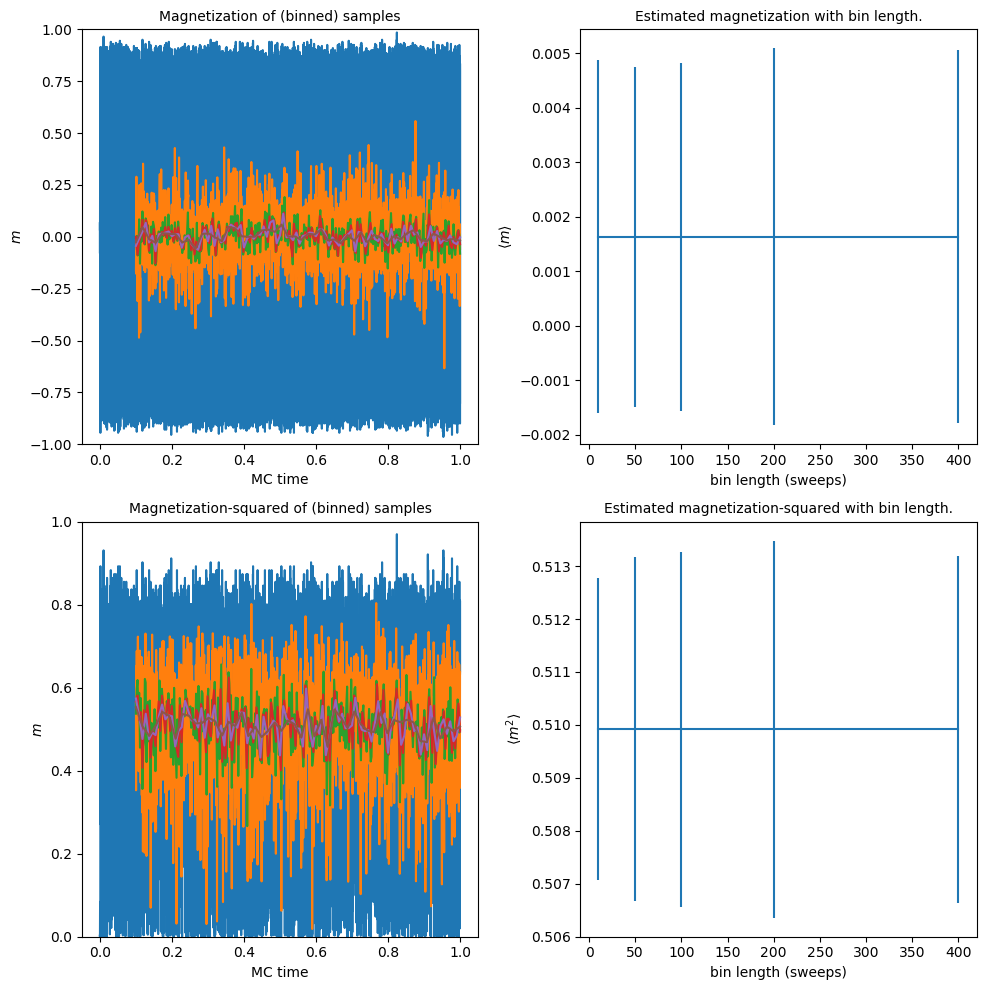

In [20]:
let Lx = 20, Ly = 20, T = 2.269, Nsweep = 22000, Nburn = 2000
    
    lbins = Int[10, 50, 100, 200, 400]
    
    N = Lx * Ly
    c = bitrand(Ly,Lx)
    meas, c_fracs = ising_MC_cluster_2D_PBC(c, 1.0/T, Nsweep, Nmeas=2, measfunc=ising_meas_mag_2D_PBC!)
    @show mean(c_fracs)
    
    meas = meas'
    ms = meas[:,1]
    m2s = meas[:,2]
    
    figure(figsize=(10,10))
    subplot(221)
    plot(linspace(0.0, 1.0, length(ms)), ms, label="1")
    
    ms = ms[Nburn+1:end] #burn-in
    
    avs = zeros(length(lbins))
    stds = zeros(length(lbins))
    
    for (j, lbin) in enumerate(lbins)
        msb = binmeas(ms, lbin)
        plot(linspace(0.1, 1.0, length(msb)), msb, label="$lbin")
        avs[j], stds[j] = measval(msb)
    end
    
    ylim((-1,+1))
    xlabel("MC time")
    ylabel(L"m")
    title("Magnetization of (binned) samples", fontsize=10)
    #legend()
    
    subplot(222)
    errorbar(lbins, avs, yerr=stds)
    xlabel("bin length (sweeps)")
    ylabel(L"\langle m \rangle")
    title("Estimated magnetization with bin length.", fontsize=10)

 
    subplot(223)
    plot(linspace(0.0, 1.0, length(m2s)), m2s, label="1")
    
    m2s = m2s[Nburn+1:end] #burn-in
    
    avs = zeros(length(lbins))
    stds = zeros(length(lbins))
    
    for (j, lbin) in enumerate(lbins)
        m2sb = binmeas(m2s, lbin)
        plot(linspace(0.1, 1.0, length(m2sb)), m2sb, label="$lbin")
        avs[j], stds[j] = measval(m2sb)
    end
    
    ylim((0,+1))
    xlabel("MC time")
    ylabel(L"m")
    title("Magnetization-squared of (binned) samples", fontsize=10)
    #legend()
    
    subplot(224)
    errorbar(lbins, avs, yerr=stds)
    xlabel("bin length (sweeps)")
    ylabel(L"\langle m^2 \rangle")
    title("Estimated magnetization-squared with bin length.", fontsize=10)
    
    tight_layout()
end

We observe a lack of jumps in the magnetization, much better convergence of the error bars with bin size, and much smaller errors!